In [1]:
from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw
# import netgen.gui

import numpy as np

$$
\DeclareMathOperator{\Grad}{grad}
\DeclareMathOperator{\Curl}{curl}
\DeclareMathOperator{\Div}{div}
\DeclareMathOperator{\R}{\mathbb{R}}
\DeclareMathOperator{\real}{real}
$$
In the following document we are going too solve the [TEAM 7 problem](https://www.compumag.org/wp/wp-content/uploads/2018/06/problem7.pdf) in two different ways. In one version the impressed current density $J$ is given directly, in the other model we use a vector potential $T_0$ to state the right hand side. This leads to the following weak formulations.

For the first version we have to find a $ u \in H(\Curl)$ such that 
$$
\int_{\Omega} \mu^{-1} \Curl u \Curl v + i\omega\sigma \int_{\Omega} u  v = \int_{\Omega} J v \qquad  \forall \, v \in H(\Curl) \tag{1}.
$$

If we use the vector potential, we are looking for a $ u \in H(\Curl)$ such that 
$$
\int_{\Omega} \mu^{-1} \Curl u \Curl v + i\omega\sigma \int_{\Omega} u  v = \int_{\Omega} T_0 \Curl v \qquad  \forall \, v \in H(\Curl) \tag{2}.
$$


If we model the current density directly, we have to take care that we use a mesh with curved elements to get accurate results. 

We begin by building the geometry according to the outline below. Therefore we split the coil in eight parts. This is also going to help us define the impressed current density later on. Note that the measurements in Figure 1 are given in mm, whereas we are going to use SI-units.
![geometry](geo.png)


In [2]:
a = 0.150 # width of hole in coil
l = 0.294 # length of aluminium plate
r = 0.025  # width of coil


h0 = 0.019  # hight of aluminium plate
h1 = 0.03 # hight of air gap
h2 = 0.1 # hight of coil

# x-y coordinates of vertices for coil 
'''(Eckpunkte des die Spule umschließenden Quaders, wie sag ich das auf Englisch?)'''
cv = [(l-a-2*r,0), (l,0), (l,a+2*r), (l-a-2*r,a+2*r)]

# x-y coordinates of centers of circles for corners
cc = [(l-a, 2*r), (l-2*r, 2*r), (l-2*r, a), (l-a, a)]

# x-y coordinates of vertices for hole
hole_vertices = [(0.018, 0.018), (0.126, 0.126)]

d = 0.050 # extra space between geometry and enclosing box


geo = CSGeometry()

''' warum brauch ich '-1e-3' damit es funktioniert? '''
p = cv.copy()
p[0] = (p[0][0], -1e-3)

maxh_corners = 0.1

# corners
corners = []
'''
########## was ich gerne haette ##########
for i in range(4):
    corners += [(Cylinder(Pnt(cc[i]+(0,)), Pnt(cc[i]+(1,)), 2*r) - Cylinder(Pnt(cc[i]+(0,)), Pnt(cc[i]+(1,)), r)) * \
       OrthoBrick(Pnt(p[i]+(h0+h1,)),Pnt(cc[i]+(h0+h1+h2,)))]
####################
'''

'''########## was ich stattdessen mache ##########'''
corners += [(Cylinder(Pnt(cc[0]+(0,)), Pnt(cc[0]+(1,)), 2*r) - Cylinder(Pnt(cc[0]+(0,)), Pnt(cc[0]+(1,)), r)) * \
             OrthoBrick(Pnt(p[0]+(h0+h1,)),Pnt(cc[0]+(h0+h1+h2,))).mat('corner0').maxh(maxh_corners)]
corners += [(Cylinder(Pnt(cc[1]+(0,)), Pnt(cc[1]+(1,)), 2*r) - Cylinder(Pnt(cc[1]+(0,)), Pnt(cc[1]+(1,)), r)) * \
             OrthoBrick(Pnt(p[1]+(h0+h1,))-Vec(2*r, 0,0),Pnt(cc[1]+(h0+h1+h2,))+Vec(2*r,0,0)).mat('corner1').maxh(maxh_corners)]
corners += [(Cylinder(Pnt(cc[2]+(0,)), Pnt(cc[2]+(1,)), 2*r) - Cylinder(Pnt(cc[2]+(0,)), Pnt(cc[2]+(1,)), r)) * \
             OrthoBrick(Pnt(cc[2]+(h0+h1,)),Pnt(p[2]+(h0+h1+h2,))).mat('corner2').maxh(maxh_corners)]
corners += [(Cylinder(Pnt(cc[3]+(0,)), Pnt(cc[3]+(1,)), 2*r) - Cylinder(Pnt(cc[3]+(0,)), Pnt(cc[3]+(1,)), r)) * \
             OrthoBrick(Pnt(p[3]+(h0+h1,))-Vec(0,2*r,0), Pnt(cc[3]+(h0+h1+h2,))+Vec(0,2*r,0)).mat('corner3').maxh(maxh_corners)]
'''####################'''


# bricks
b0 = [(l-a,0), (l-r,2*r), (l-a,a+r), (l-a-2*r,2*r)]
b1 = [(l-2*r,r),(l,a), (l-2*r,a+2*r), (l-a-r,a)]
bricks = []
for i in range(4):
    bricks += [OrthoBrick(Pnt(b0[i]+(h0+h1,)), Pnt(b1[i]+(h0+h1+h2,))).mat('brick{}'.format(i))]

plate = (OrthoBrick(Pnt(0,0,0), Pnt(l,l,h0)) -
            OrthoBrick(Pnt(hole_vertices[0]+(0,)), Pnt(hole_vertices[1]+(h0,)))).mat('plate')


box = OrthoBrick(Pnt(0-d, 0-d, 0-d), Pnt(p[2][0]+d, l+d, h0+h1+h2+d)).bc("outer")
air = (box - sum(bricks) - sum(corners) - plate).mat('air')
    

geo.Add(air, transparent=True)
geo.Add(plate)
for i in range(4):
    geo.Add(corners[i])
    geo.Add(bricks[i])
    
# generate mesh
mesh = Mesh(geo.GenerateMesh(maxh=0.1))
mesh.Curve(10)

Draw(mesh)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

Now we can define the direction of the impressed current. The generated vector field $J_n$ is normalized inside the coil and zero elsewhere.

In [3]:
sor = 1 # sense of rotation

n = lambda center: CoefficientFunction(sqrt((x-center[0])**2+(y-center[1])**2))
sd = {
    'corner0': (-sor*(y-cc[0][1])/n(cc[0]),sor*(x-cc[0][0])/n(cc[0]),0) ,
    'corner1': (-sor*(y-cc[1][1])/n(cc[1]),sor*(x-cc[1][0])/n(cc[1]),0) , 
    'corner2': (-sor*(y-cc[2][1])/n(cc[2]),sor*(x-cc[2][0])/n(cc[2]),0) ,
    'corner3': (-sor*(y-cc[3][1])/n(cc[3]),sor*(x-cc[3][0])/n(cc[3]),0) ,
    'brick0': (sor*1,0,0) ,
    'brick1': (0,sor*1,0) ,
    'brick2': (-sor*1,0,0) ,
    'brick3': (0,-sor*1,0)
}
coil_mat = ['corner0','corner1', 'corner2','corner3','brick0','brick1','brick2','brick3']
Jn = CoefficientFunction([sd[mat] if mat in sd.keys() else (0,0,0) for mat in mesh.GetMaterials()])

Draw (Jn, mesh, draw_surf=False)

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

Next we generate a vector potential $T_0$ such that $\Curl T_0 = J_n$.

NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

<IPython.core.display.Javascript object>


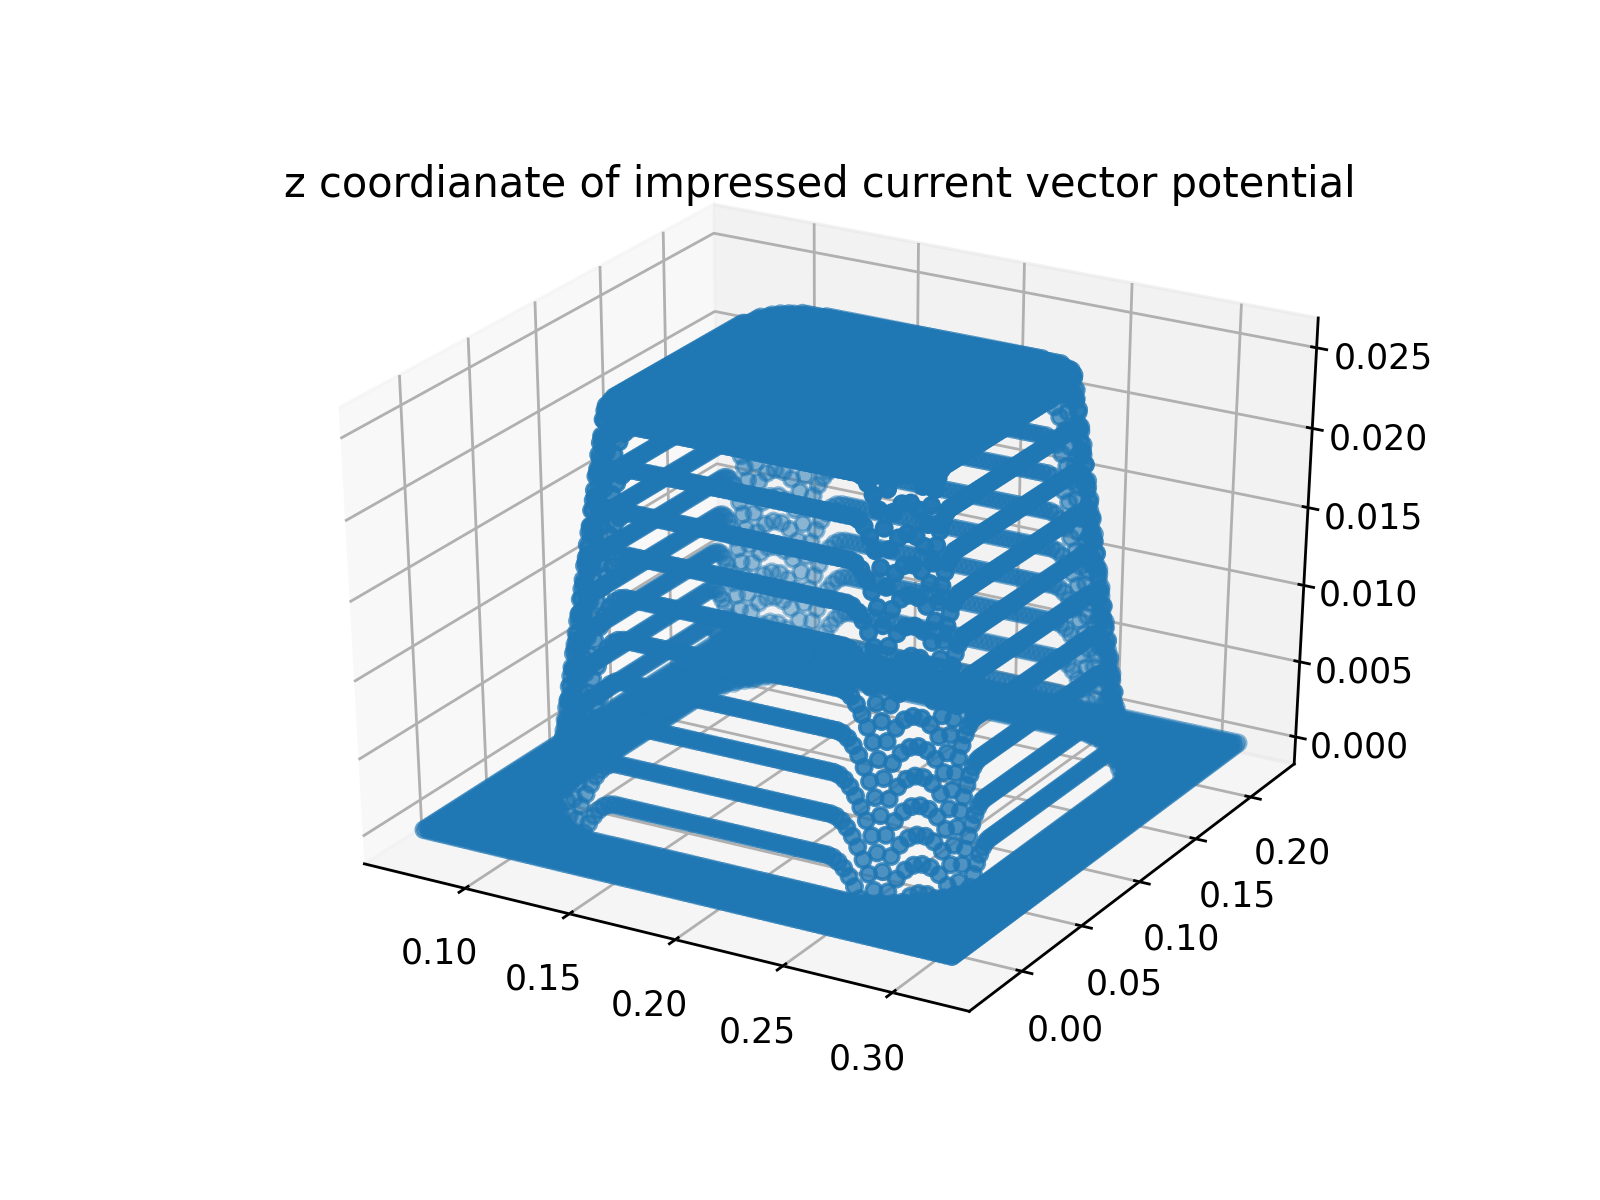

Text(0.5, 0.92, 'z coordianate of impressed current vector potential')

In [4]:
%matplotlib notebook
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d    
import numpy as np

def T0z_pw(x,y, sor=1):
    
    # check if x is in area 1 or 2
    if (x >= cv[0][0] and x<cc[0][0]):
        
        # check if y is in area D or E
        if (y >= cv[0][1] and y<cc[0][1]):
            
            dist = lambda p: sqrt((p[0]-cc[0][0])**2+(p[1]-cc[0][1])**2)
            if dist((x,y)) > 2*r: return (0)
            elif dist((x,y)) < r: return (sor*r)
            else: return (sor*(2*r-dist((x,y))))
        
        # check if y is in area C
        elif (y >= cc[0][1] and y < cc[3][1]):
            
            if (x <= cv[0][0]+r): 
                return(sor*(x-cv[0][0]))
            else: return (sor*r)
        
        # check if y is in area A or B
        elif (y >= cc[3][1] and y <= cv[3][1]):
            
            dist = lambda p: sqrt((p[0]-cc[3][0])**2+(p[1]-cc[3][1])**2)
            if dist((x,y)) > 2*r: return (0)
            elif dist((x,y)) < r: return (sor*r)
            else: return (sor*(2*r-dist((x,y))))
        
     
    # check if x is in area 3
    elif (x>= cc[0][0] and x<cc[1][0]):
        
        # check if y is in area E
        if (y>cv[0][1] and y < cv[0][1]+r):
            return(sor*y)
        
        # check if y is in area B to D
        elif (y >= cv[0][1]+r and y < cv[3][1]-r): 
            return (sor*r)
        
        # check if y is in area A
        elif (y >= cv[3][1]-r and y < cv[3][1]):
            return(-sor*(y-cv[3][1]))

    # check if x is in area 4 or 5
    elif (x >= cc[1][0] and x <= cv[1][0]):
        
        # check if y is in area D or E
        if (y>=cv[0][1] and y<cc[0][1]):
            
            dist = lambda p: sqrt((p[0]-cc[1][0])**2+(p[1]-cc[1][1])**2)
            if dist((x,y)) > 2*r: return (0)
            elif dist((x,y)) < r: return (sor*r)
            else: return (sor*(2*r-dist((x,y))))
        
        # check if y is in area C
        elif (y >= cc[0][1] and y < cc[3][1]):
            
            if ( x >= cv[1][0]-r): 
                return(-sor*(x-cv[1][0]))
            
            else: return (float(sor*r))
        
        # check if y is in area A or B
        elif (y >= cc[3][1] and y <= cv[3][1]):
            
            dist = lambda p: sqrt((p[0]-cc[2][0])**2+(p[1]-cc[2][1])**2)
            if dist((x,y)) > 2*r: return (0)
            elif dist((x,y)) < r: return (sor*r)
            else: return (sor*(2*r-dist((x,y))))
            
    return (0.0)

T0z = np.vectorize(T0z_pw)

N = 3000

x_lin = np.linspace(cv[0][0]-r, cv[1][0]+r, N)
y_lin = np.linspace(cv[0][1]-r, cv[3][1]+r, N)

values = T0z(x_lin[:,None], y_lin[None,:])
values = values.reshape(1,len(x_lin),len(y_lin)).astype(float)

vc = VoxelCoefficient((cv[0][0]-r,cv[0][1]-r,h0+h1-r), 
        (cv[1][0]+r,cv[3][1]+r,h0+h1+h2+r), values, linear=True)
T0 = IfPos(h0+h1+h2+0.005-z, IfPos(z-h0-h1+0.005, vc, 0), 0)


# visualization
Draw(T0, mesh)

ind = slice(0,N,30)
fig = plt.figure(0)
ax = plt.axes(projection='3d')

X, Y = np.meshgrid(x_lin[ind], y_lin[ind])
ax.scatter(X, Y, np.array(values[0,ind,ind]).reshape(len(x_lin[ind]), len(y_lin[ind])))
plt.title('z coordianate of impressed current vector potential')


At last we can solve the problem for both versions.

In [5]:
fes = HCurl(mesh, order = 4, dirichlet="outer", complex = True)#, nograds=True,)
u,v = fes.TnT()
print("degrees of freedom: ", fes.ndof)

# physical constants
mu0 = 4*np.pi*1e-7 
curdens = 2742/(r*h2) # impressed current density in m
omega = 2*np.pi*50 # angular velocity
sigma = 3.526e7 # conductivity

# nu = CoefficientFunction([1./(1000*mu0) if mat in coil_mat else 1./mu0  for mat in mesh.GetMaterials()])
nu = 1/mu0

# regularization term and conductivity term
kappa = CoefficientFunction([1j*omega*sigma if mat=='plate' else 1e-6*nu for mat in mesh.GetMaterials()])

a = BilinearForm(fes)
a += nu*curl(u)*curl(v)*dx + kappa*u*v*dx 
c = Preconditioner(a, "bddc")

# formulation with impressed current density
f1 = LinearForm(fes)
f1 += CoefficientFunction(curdens)*Jn*v*dx

# formulation with vector potential
f2 = LinearForm(fes)
f2 += CoefficientFunction(curdens)*T0*CoefficientFunction((0,0,1))*curl(v)*dx

# solve the problems
with TaskManager():
    
    a.Assemble()
    f1.Assemble()
    gfu1 = GridFunction(fes)

    f2.Assemble()
    gfu2 = GridFunction(fes)
    
    solvers.CG(sol=gfu1.vec, rhs=f1.vec, mat=a.mat, pre=c.mat, tol=1e-15, printrates=False)#, maxsteps=300)#
    solvers.CG(sol=gfu2.vec, rhs=f2.vec, mat=a.mat, pre=c.mat, tol=1e-15, printrates=False)#, maxsteps=300)#


degrees of freedom:  379970
iteration 0 error = 1.9884772580265295
iteration 1 error = 1.2030547840970867
iteration 2 error = 0.9070120049551091
iteration 3 error = 0.7820758457387518
iteration 4 error = 0.9855596965452467
iteration 5 error = 0.766675894321518
iteration 6 error = 1.0155231971529475
iteration 7 error = 0.5180090713066602
iteration 8 error = 0.6248851001868996
iteration 9 error = 0.40027401081184527
iteration 10 error = 0.40973462044454856
iteration 11 error = 0.29681168251045026
iteration 12 error = 0.15010823745134663
iteration 13 error = 0.25789426169403495
iteration 14 error = 0.2845029830981583
iteration 15 error = 0.215929715481063
iteration 16 error = 0.07800054724688889
iteration 17 error = 0.05401646643928764
iteration 18 error = 0.059868252635522624
iteration 19 error = 0.07902230871490445
iteration 20 error = 0.046013381064710306
iteration 21 error = 0.05557624466353078
iteration 22 error = 0.019212148611489892
iteration 23 error = 0.02420207948560444
iteratio

iteration 93 error = 1.2917153086537807e-07
iteration 94 error = 1.849674716636836e-07
iteration 95 error = 1.6741693347739814e-07
iteration 96 error = 2.0999757658550832e-07
iteration 97 error = 1.242697369557101e-07
iteration 98 error = 1.001376027441665e-07
iteration 99 error = 1.0268461137019085e-07
CG did not converge to tol


In [6]:
# magnetic density fields
B1 = lambda omega_t: (curl(gfu1)*exp(1j*omega_t)).real
B2 = lambda omega_t: (curl(gfu2)*exp(1j*omega_t)).real

# eddy current density fields
E1 = lambda omega_t: (-curl(gfu1)*exp(1j*omega_t)).imag
E2 = lambda omega_t: (-curl(gfu2)*exp(1j*omega_t)).imag

In [7]:
# # visualization
print('B1')
Draw(B1(0), mesh, "B1", draw_surf=False)
print('B2')
Draw(B2(0), mesh, "B2", draw_surf=False)
print('E1')
Draw(E1(0), mesh, "E1", draw_surf=False)
print('E2')
Draw(E2(0), mesh, "E2", draw_surf=False)

B1


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

B2


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

E1


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

E2


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2008-17-g2ebed44be', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2,…

To verify and compare our results we measure the components of the B and E fields according to the description in the TEAM 7 task. The data in the tables is in millimeter and Gauss instead of Meter and Tesla, because these units are used in the original files.

<span style="color:red"> **Die Werte sind nicht gut, besonders version 2 bei 0°** Siehe plots. Generell sehr ungenau, aber bei v2 treten Oszillationen auf. Wie mache ich das Potential mir schärferer Grenze? BArauche ich noch irgendwelche Randbedingungen?</span>


<IPython.core.display.Javascript object>


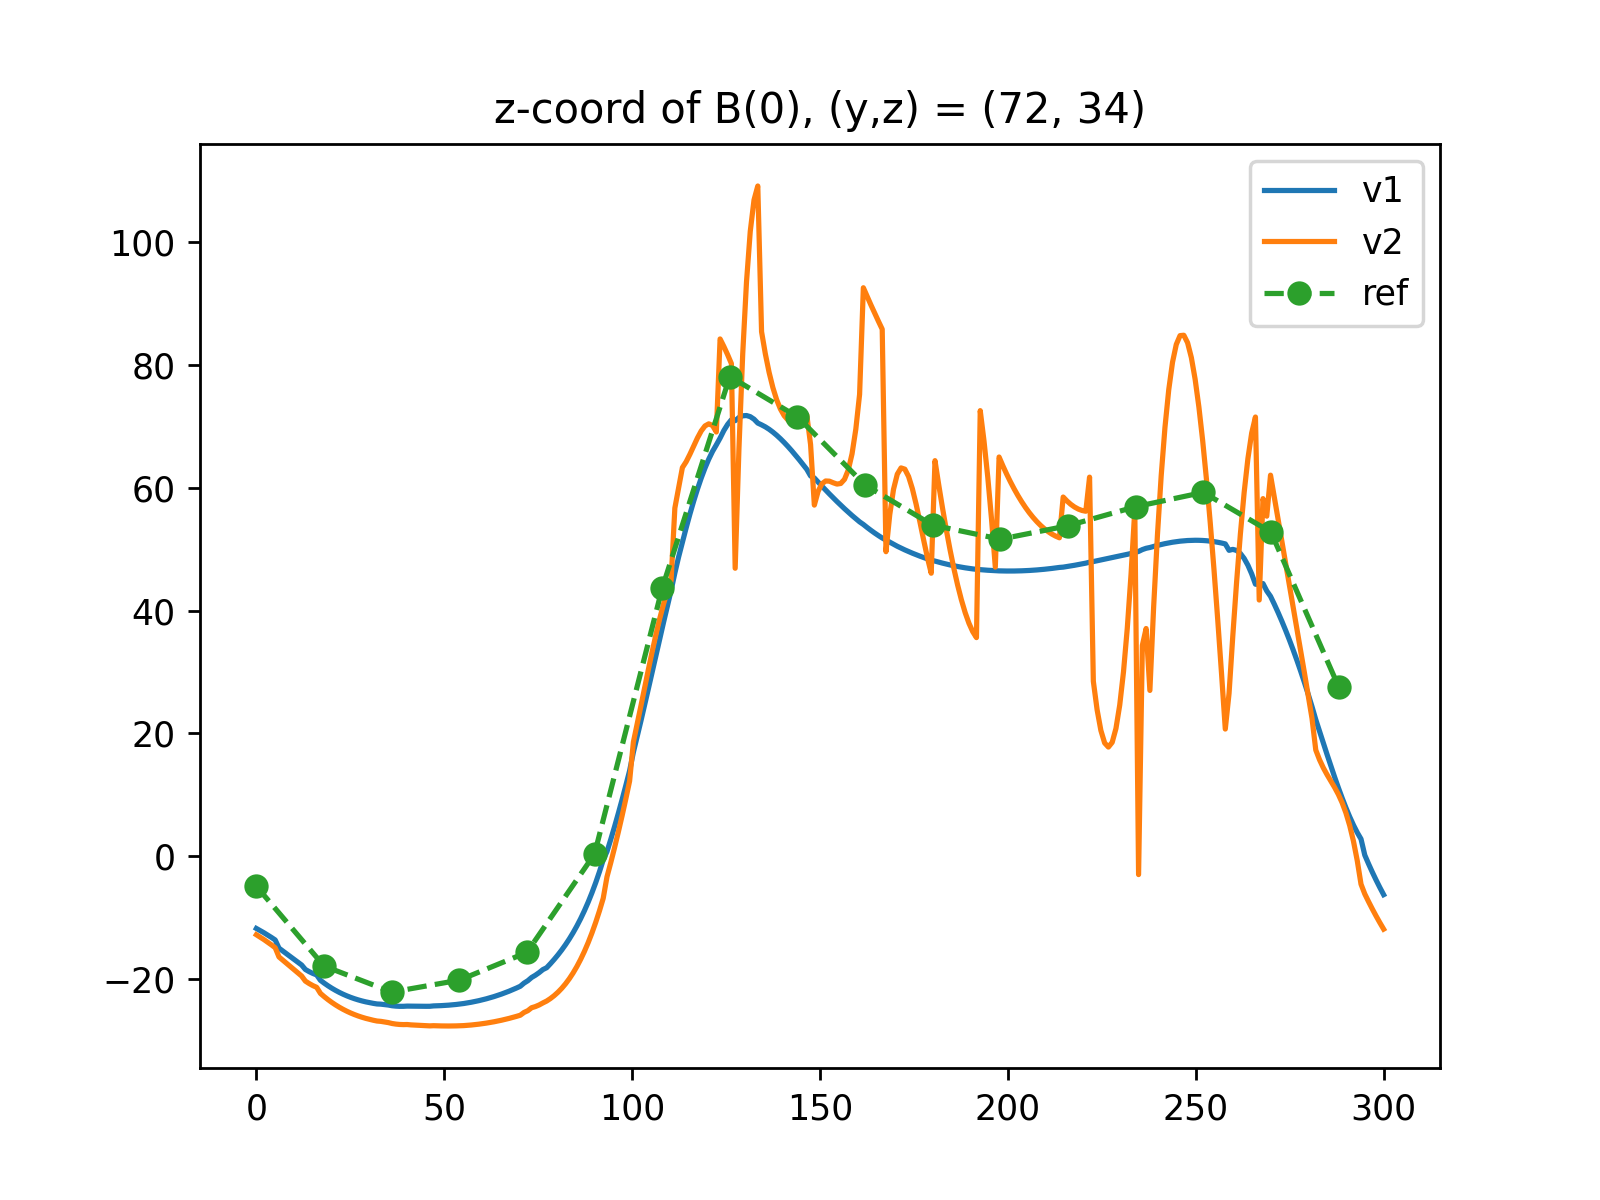

<IPython.core.display.Javascript object>


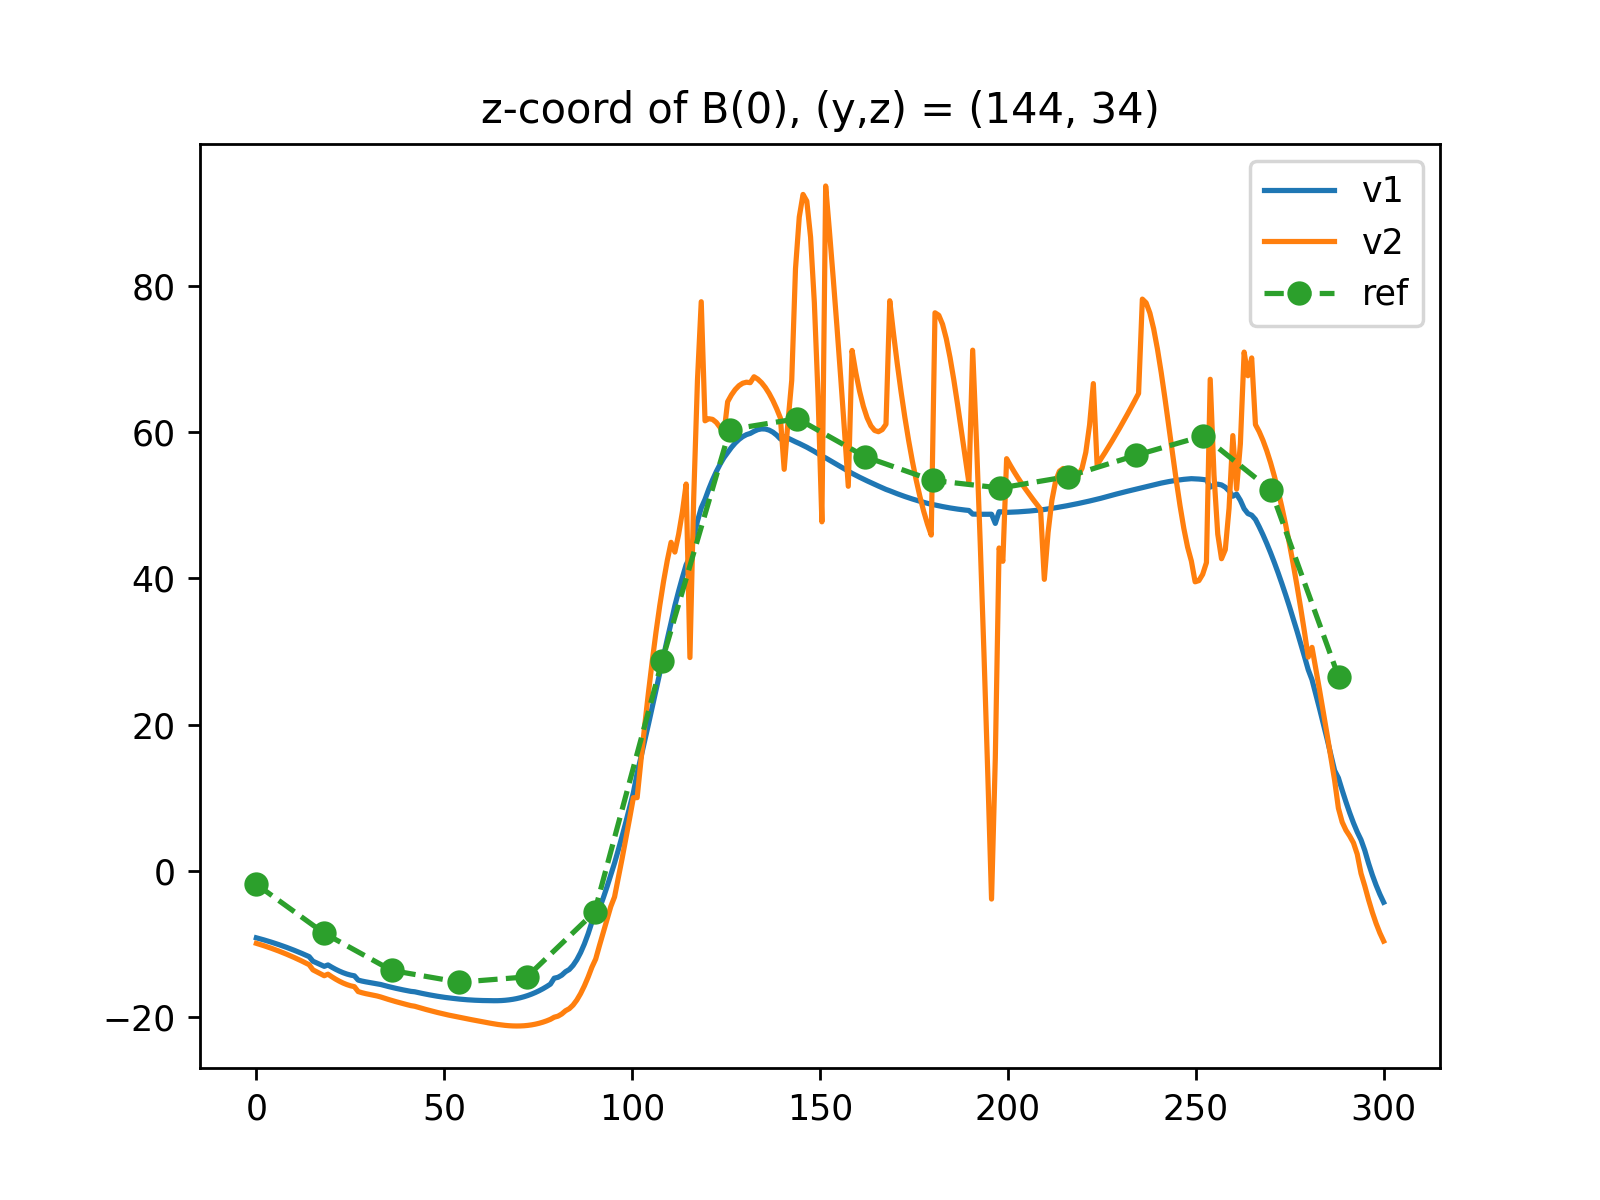

<IPython.core.display.Javascript object>


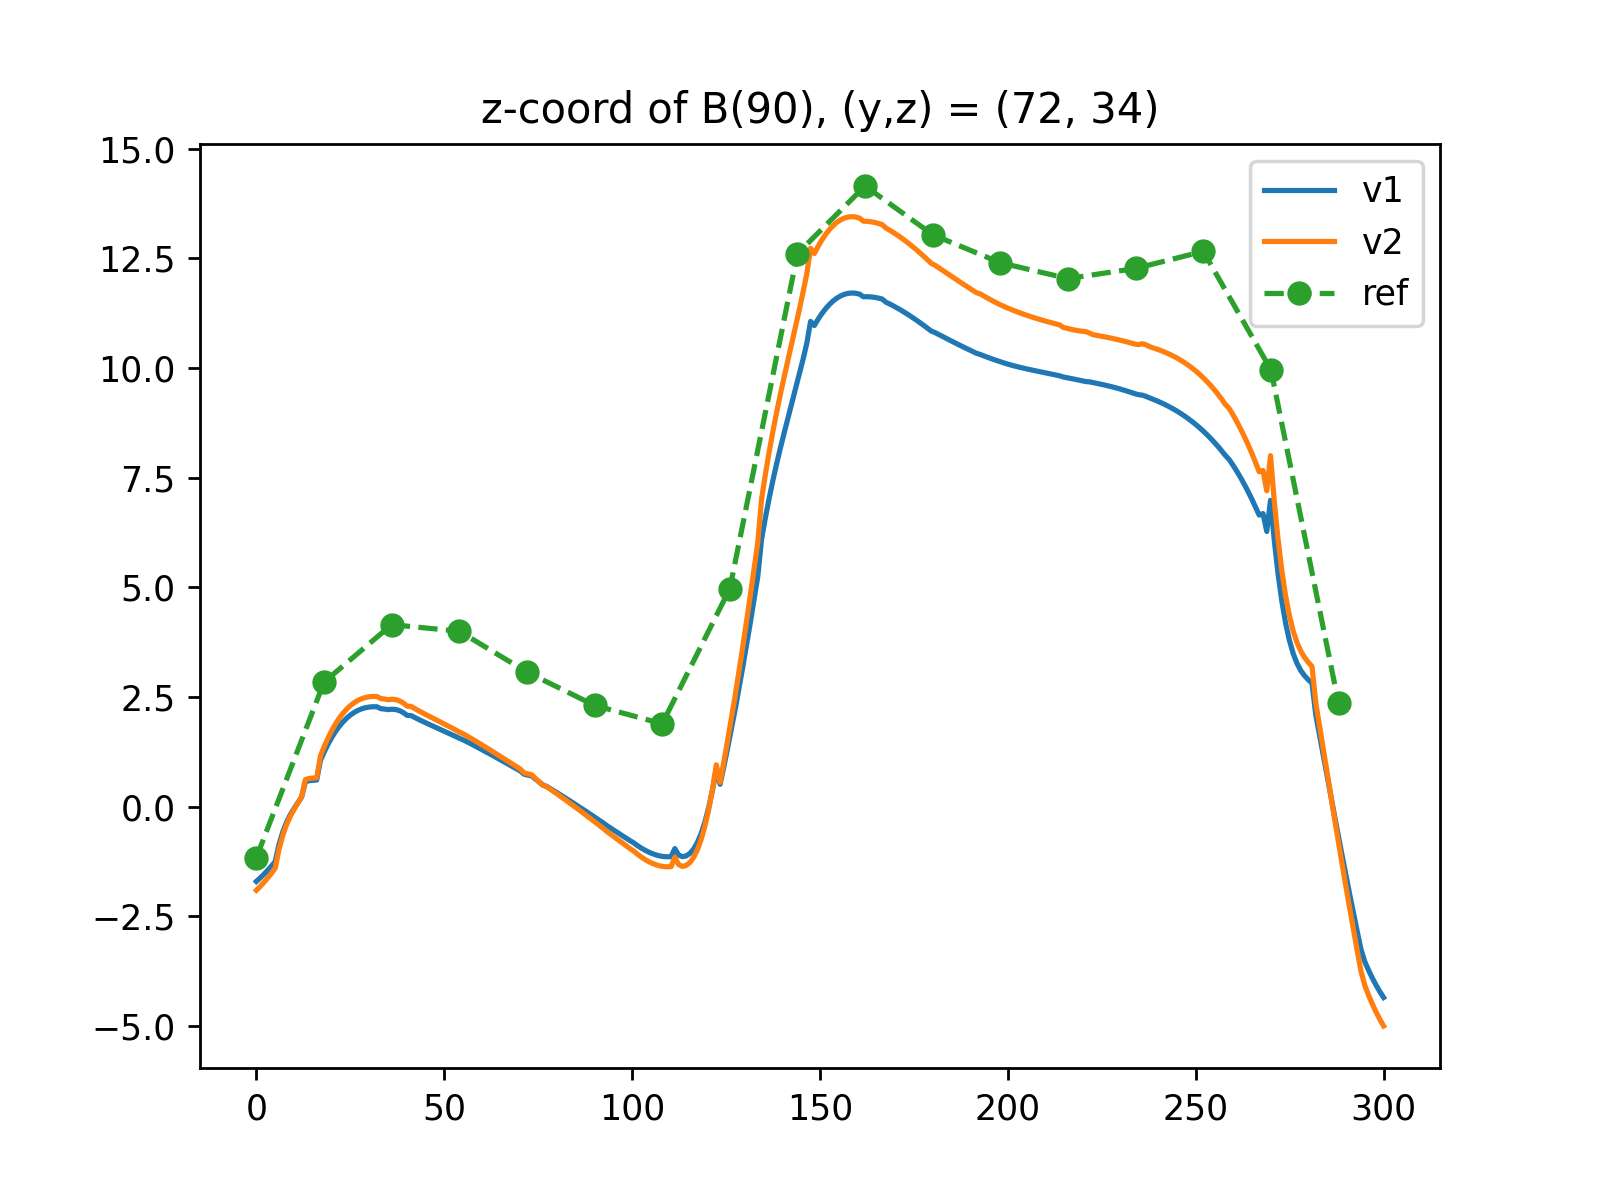

<IPython.core.display.Javascript object>


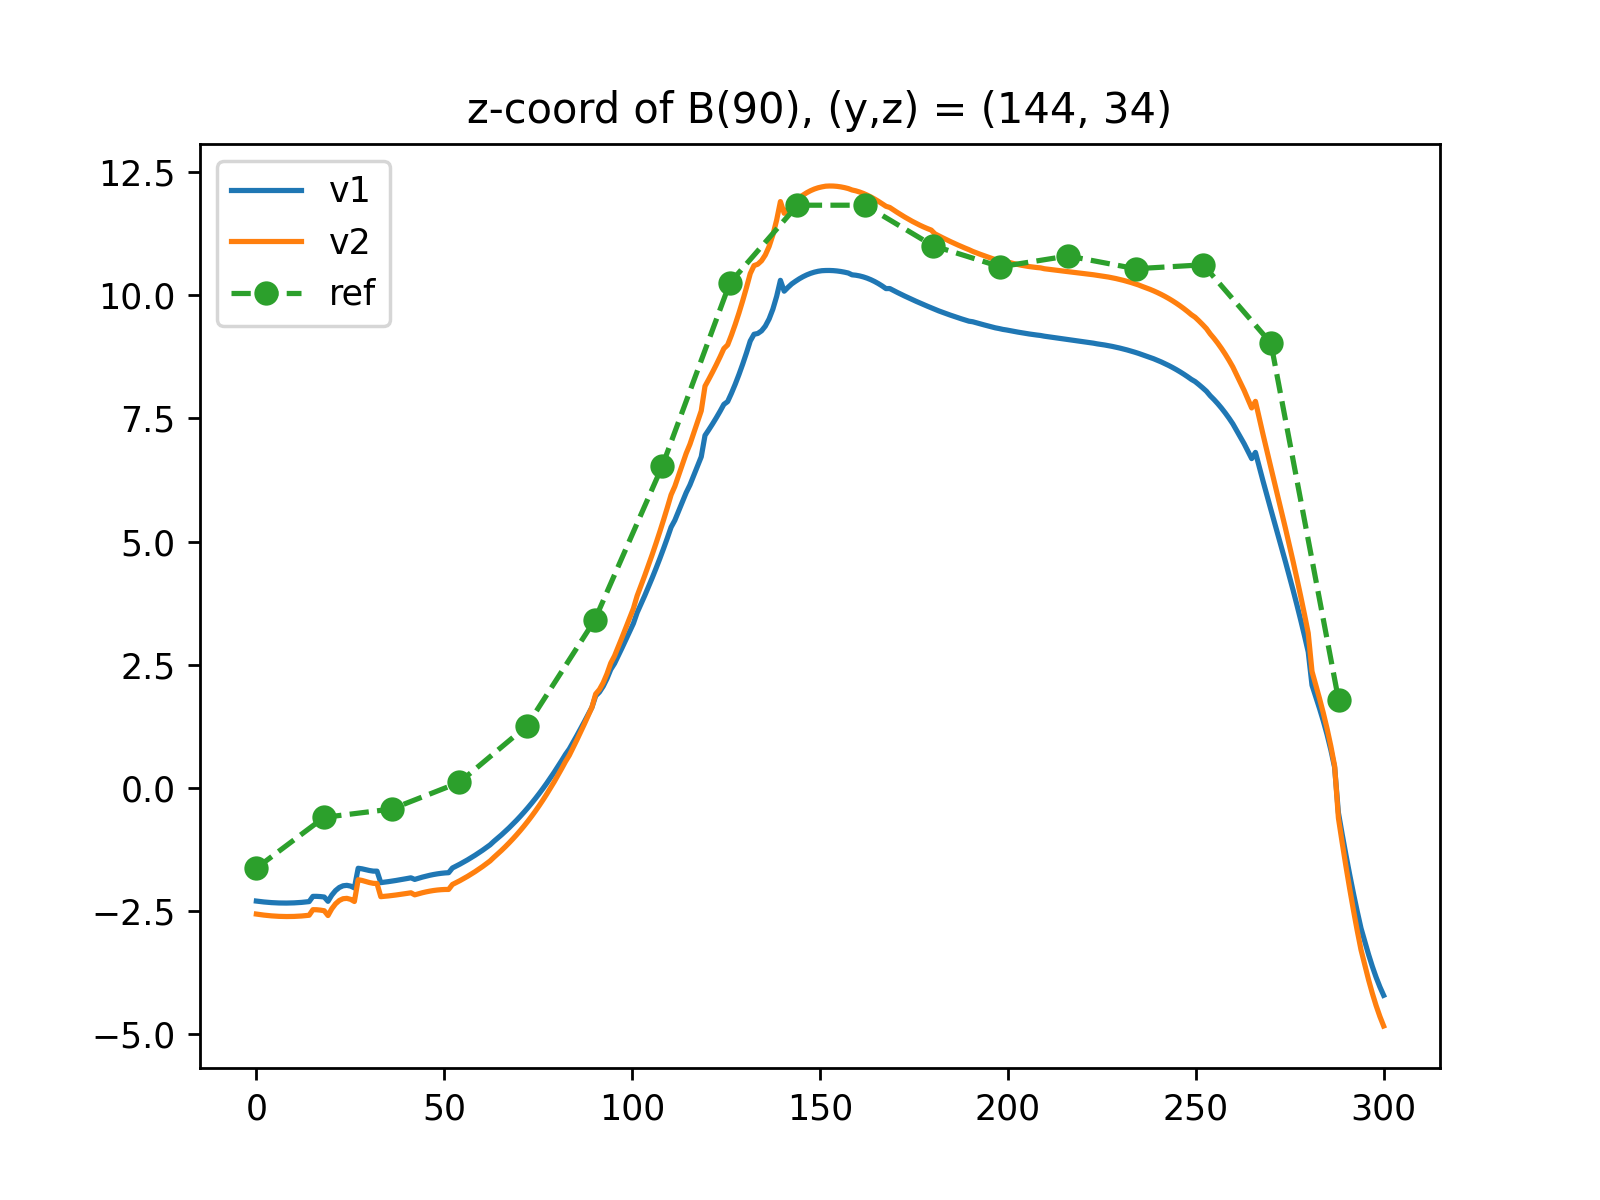

degree              0°                 90°            
version            ref     v1     v2   ref    v1    v2
(y, z)    x                                           
(72, 34)  0      -4.90 -11.77 -12.79 -1.16 -1.70 -1.91
          18    -17.88 -20.65 -22.84  2.84  1.24  1.36
          36    -22.13 -24.34 -27.23  4.15  2.22  2.45
          54    -20.19 -24.09 -27.62  4.00  1.56  1.70
          72    -15.67 -20.37 -25.23  3.07  0.73  0.75
          90      0.36  -4.83 -11.32  2.31 -0.24 -0.34
          108    43.64  37.12  40.24  1.89 -1.13 -1.36
          126    78.11  70.78  80.83  4.97  1.59  1.81
          144    71.55  64.91  70.68 12.61  9.69 11.14
          162    60.44  53.79  91.91 14.15 11.63 13.35
          180    53.91  48.16  66.89 13.04 10.84 12.38
          198    51.62  46.45  64.51 12.40 10.14 11.44
          216    53.81  47.19  57.68 12.04  9.78 10.90
          234    56.91  49.46  59.03 12.27  9.41 10.54
          252    59.24  51.41  66.72 12.66  8.56  9.78
          270    52.78  42.19  61.69  9.96  6.89  7.89
          288    27.61  11.07  10.00  2.36 -0.69 -0.82
          error   0.00  16.54  31.47  0.00  4.10  3.25
(144, 34) 0      -1.83  -9.14  -9.90 -1.63 -2.30 -2.56
          18     -8.50 -13.03 -14.31 -0.60 -2.22 -2.49
          36    -13.60 -15.91 -17.70 -0.43 -1.89 -2.19
          54    -15.21 -17.52 -20.00  0.11 -1.56 -1.89
          72    -14.48 -17.07 -21.13  1.26 -0.43 -0.70
          90     -5.62  -5.76 -12.13  3.40  1.74  1.76
          108    28.77  28.58  38.44  6.53  4.78  5.35
          126    60.34  57.62  64.72 10.25  7.94  9.11
          144    61.84  58.56  86.51 11.83 10.31 11.95
          162    56.64  53.47  62.75 11.83 10.36 12.05
          180    53.40  50.11  76.03 11.01  9.73 11.27
          198    52.36  49.10  43.61 10.58  9.32 10.71
          216    53.93  49.96  54.68 10.80  9.10 10.48
          234    56.82  52.19  64.53 10.54  8.84 10.23
          252    59.48  53.52  40.76 10.62  8.11  9.39
          270    52.08  43.39  55.66  9.03  5.65  6.50
          288    26.56  12.65   8.49  1.79 -0.52 -0.63
          error   0.00  13.91  24.67  0.00  3.38  2.53

In [8]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format


# B field dataframe

x_vec = [0,18,36,54,72, 90,108,126,144,162,
         180,198,216,234,252,270,288] + ['error']

index = pd.MultiIndex.from_product([['(72, 34)', '(144, 34)'], 
        x_vec], names=['(y, z)', 'x'])

columns = pd.MultiIndex.from_product([['0°', '90°'], ['ref', 'v1', 'v2']],
                                     names=['degree', 'version'])

Bdf = pd.DataFrame(index=index, columns=columns)

# measured values 

Bdf['0°', 'ref']['(72, 34)'] = np.array(
    [-4.9,-17.88,-22.13,-20.19,-15.67,0.36,43.64,78.11,71.55,60.44,
     53.91,51.62,53.81,56.91,59.24,52.78,27.61]+[0])
 
Bdf['0°', 'ref']['(144, 34)'] = np.array(
    [-1.83,-8.5,-13.6,-15.21,-14.48,-5.62,28.77,60.34,61.84,56.64,
        53.4,52.36,53.93,56.82,59.48,52.08,26.56]+[0])

Bdf['90°', 'ref']['(72, 34)'] = np.array(
    [-1.16,2.84,4.15,4,3.07,2.31,1.89,4.97,12.61,14.15,13.04,12.4,
        12.04,12.27,12.66,9.96,2.36]+[0])

Bdf['90°', 'ref']['(144, 34)'] = np.array(
    [-1.63,-0.60,-0.43,0.11,1.26,3.4,6.53,10.25,11.83,11.83,
    11.01,10.58,10.80,10.54,10.62,9.03,1.79]+[0])

# simulated values 

for deg in ['0','90']:
    for v in ['1','2']:
        for yz in ['(72, 34)', '(144, 34)']:
            err = 0
            for x in x_vec[:len(x_vec)-1]:
                Bdf[deg+'°','v'+v][yz, x] = \
                eval(''.join(['B',v,'(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[2]*1e4']))
                
                # relative error
#                 err = max(abs((Bdf[deg+'°','v'+v][yz, x] - 
#                         Bdf[deg+'°','ref'][yz, x])/Bdf[deg+'°','ref'][yz, x]), err)

                # absolute error
                err = max(abs(Bdf[deg+'°','v'+v][yz, x] - Bdf[deg+'°','ref'][yz, x]), err)
        
            Bdf[deg+'°','v'+v][yz, 'error'] = err


# visualization

ind = slice(0,len(x_vec)-1)
x_ax = np.linspace(0,300,300)
cnt = 1
for deg in ['0','90']:
    for yz in ['(72, 34)', '(144, 34)']:
        
        plt.figure(cnt).clf()
        plt.figure(cnt)
        plt.plot(x_ax, [eval(''.join(['B1(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[2]*1e4'])) for x in x_ax], label='v1')
        plt.plot(x_ax, [eval(''.join(['B2(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[2]*1e4'])) for x in x_ax], label='v2')
        plt.plot(x_vec[ind], Bdf[deg+'°', 'ref'][yz][ind], '--o', label='ref')

        plt.title('z-coord of B({}), (y,z) = {}'.format(deg,yz))
        plt.legend()
        
        cnt+= 1
        
  
# show table 
Bdf

Values in Team example given as $10^6 A/m^2$. 

<IPython.core.display.Javascript object>


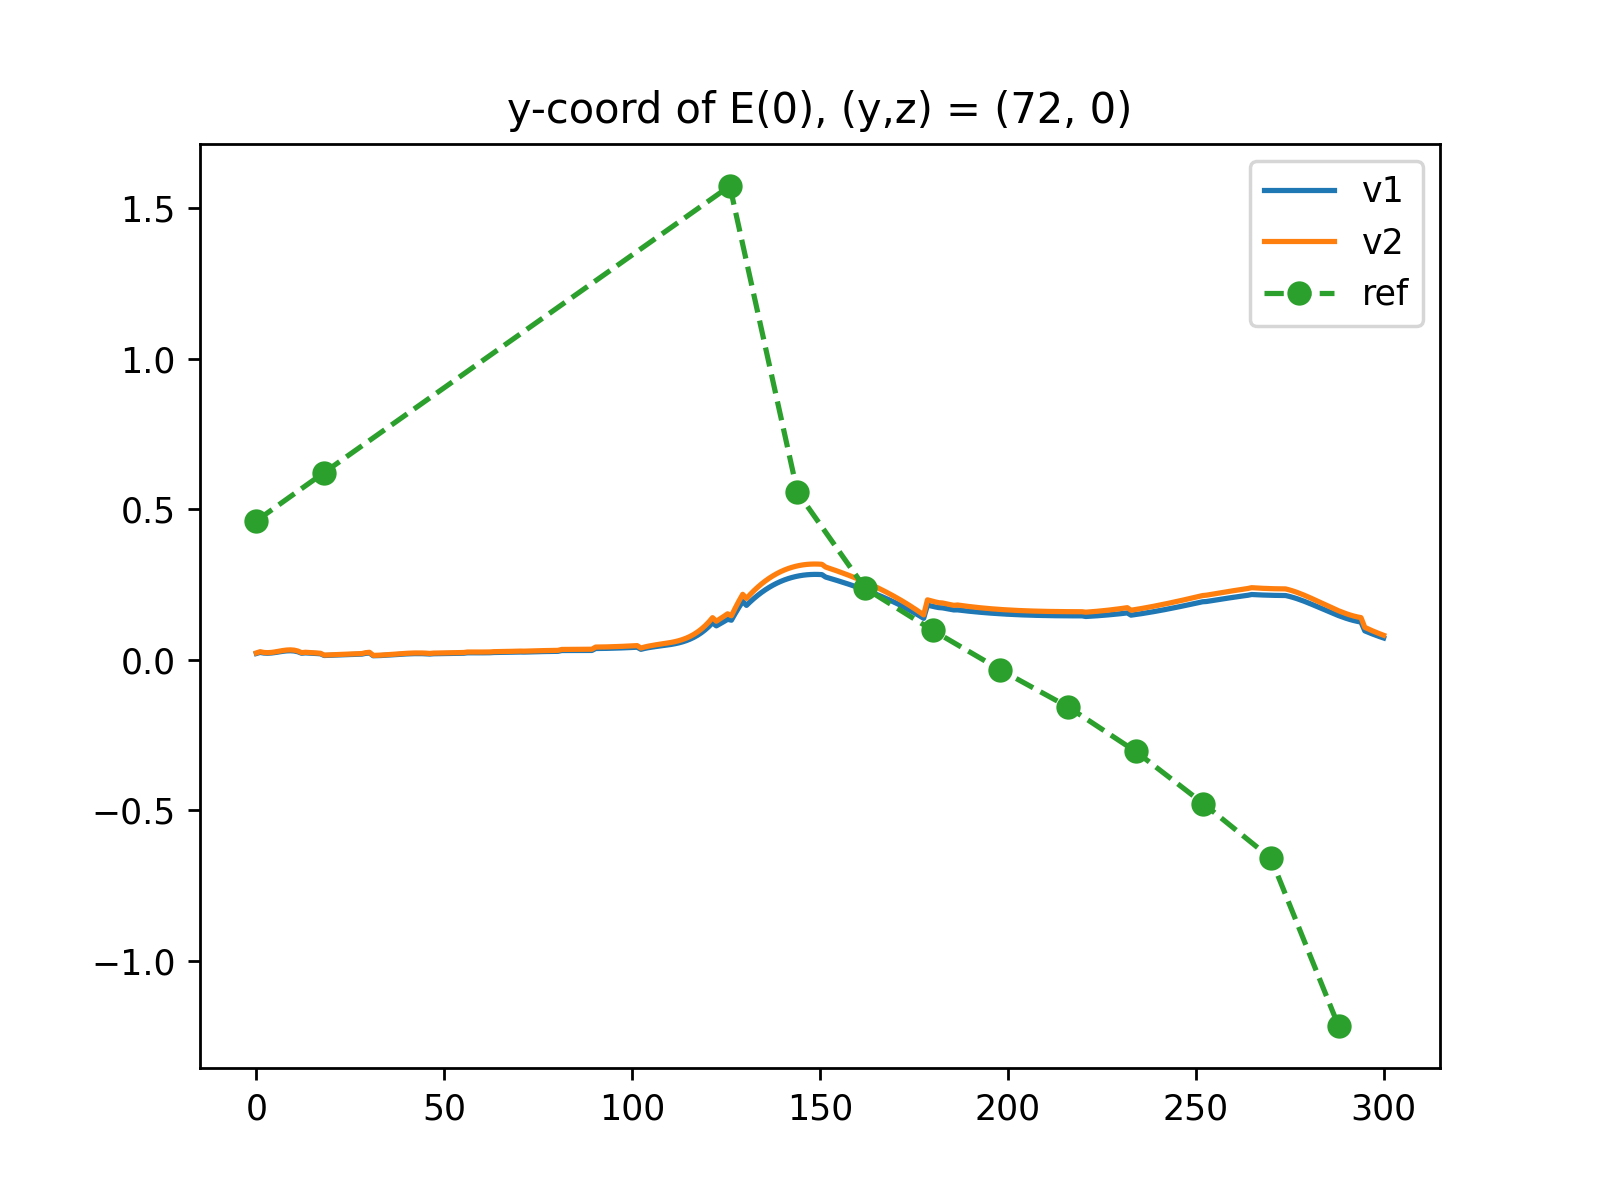

<IPython.core.display.Javascript object>


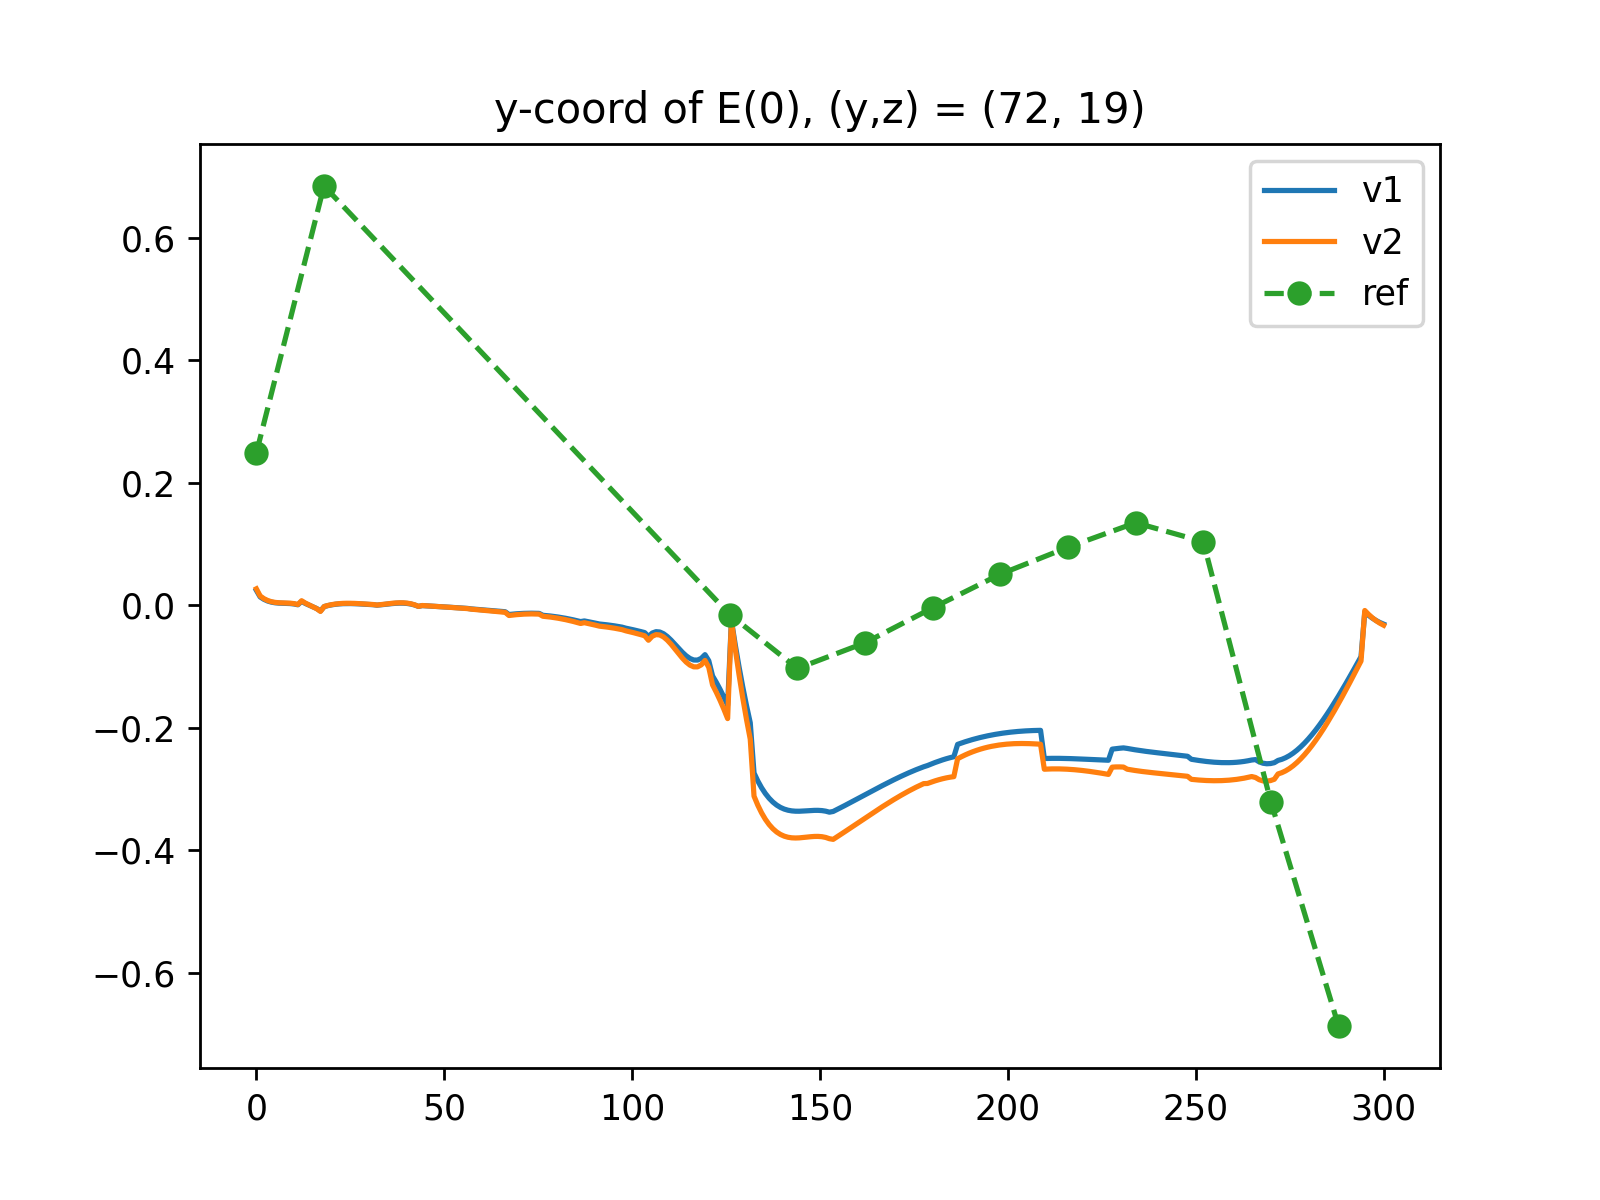

<IPython.core.display.Javascript object>


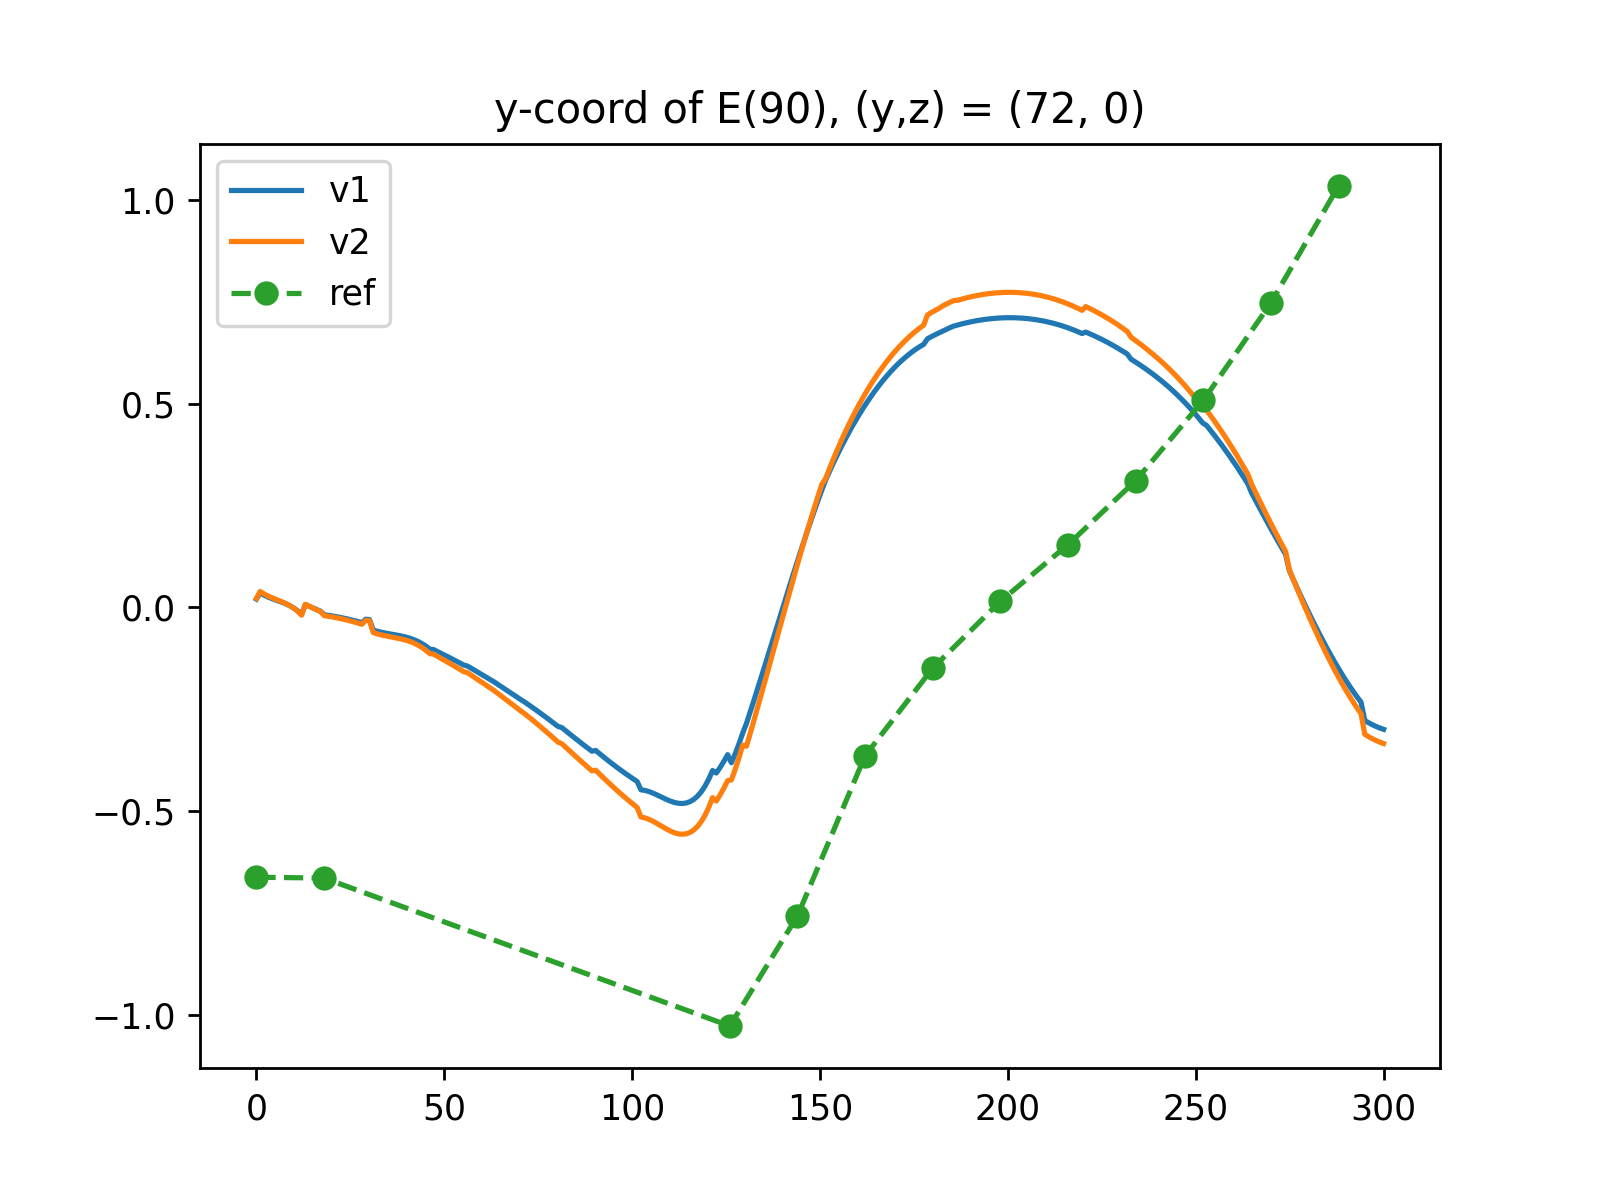

<IPython.core.display.Javascript object>


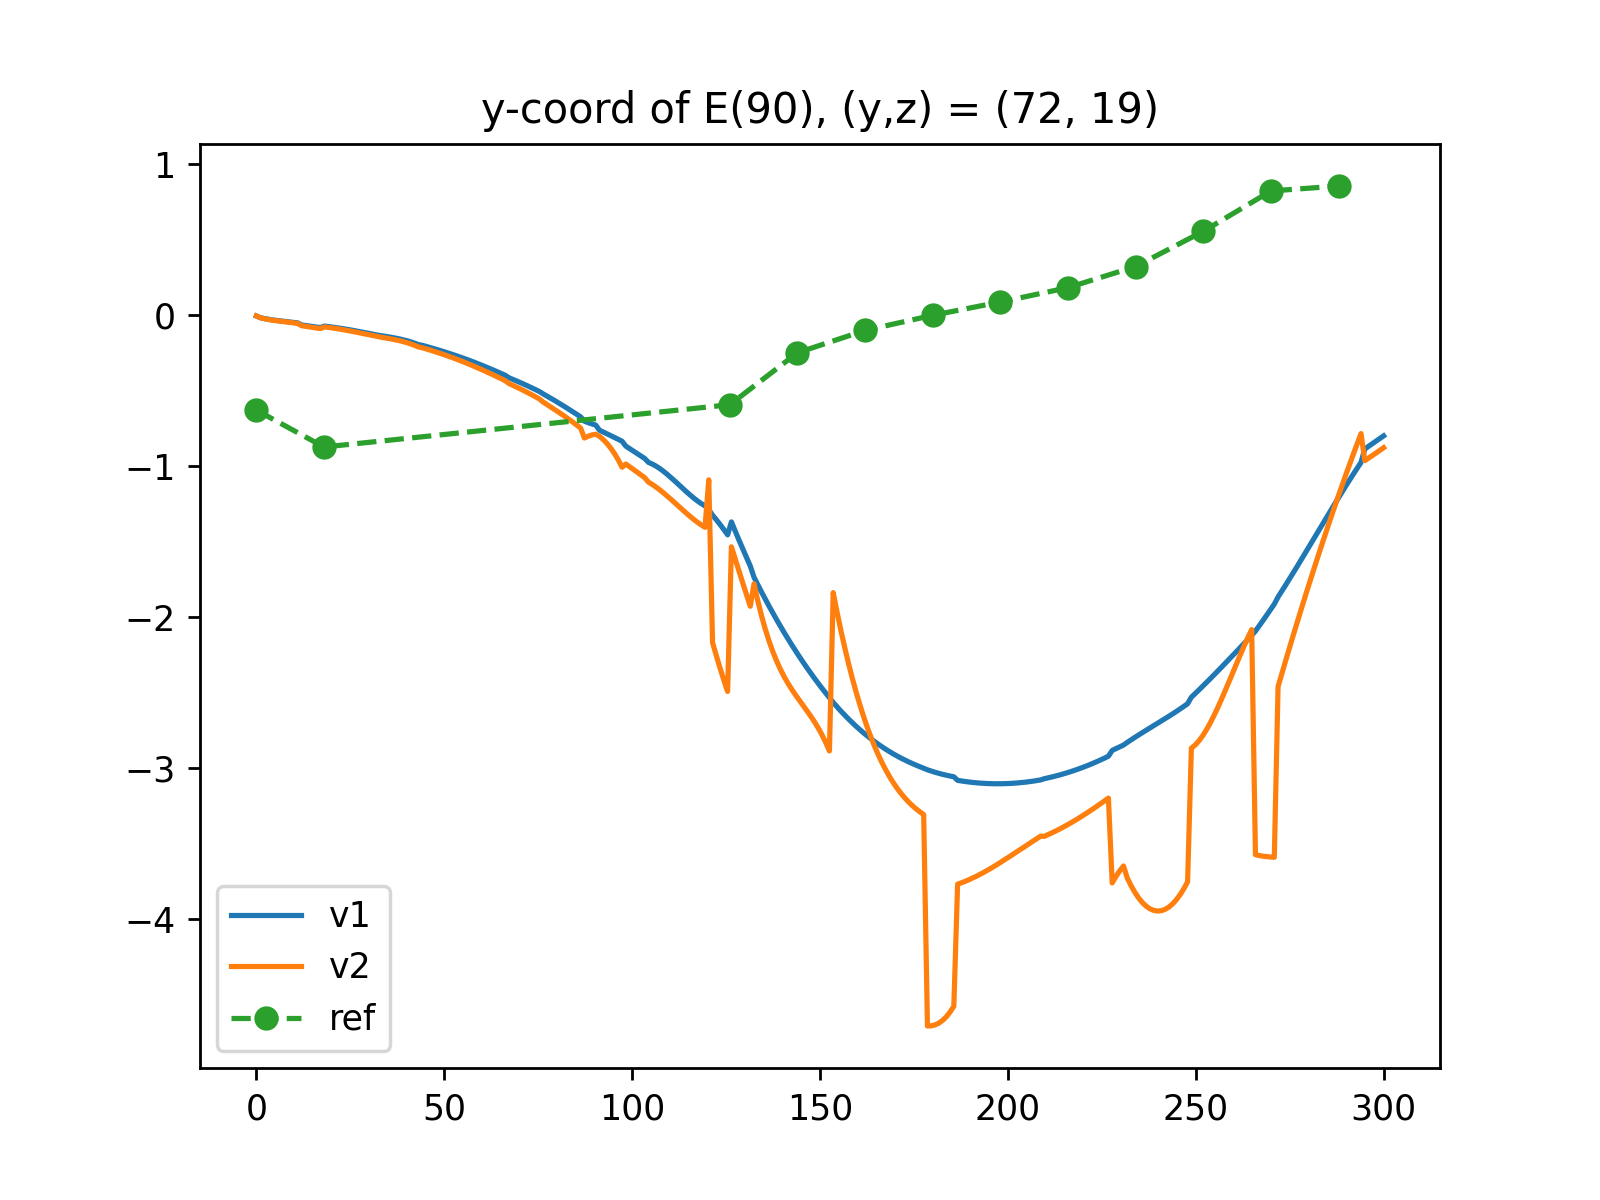

degree            0°               90°            
version          ref    v1    v2   ref    v1    v2
(y, z)   x                                        
(72, 19) 0      0.25  0.02  0.03 -0.63 -0.01 -0.01
         18     0.69 -0.03 -0.04 -0.87 -0.10 -0.10
         126   -0.01 -0.01 -0.00 -0.59 -1.34 -1.50
         144   -0.10 -0.34 -0.38 -0.25 -2.24 -2.53
         162   -0.06 -0.31 -0.35 -0.10 -2.77 -2.69
         180   -0.00 -0.26 -0.29 -0.00 -3.02 -4.70
         198    0.05 -0.21 -0.23  0.09 -3.10 -3.62
         216    0.10 -0.25 -0.27  0.18 -3.03 -3.37
         234    0.14 -0.24 -0.27  0.32 -2.79 -3.83
         252    0.10 -0.25 -0.29  0.56 -2.45 -2.78
         270   -0.32 -0.26 -0.29  0.82 -1.95 -3.59
         288   -0.69 -0.15 -0.16  0.85 -1.21 -1.19
         error  0.00  0.72  0.72  0.00  3.21  4.70
(72, 0)  0      0.46  0.02  0.02 -0.66  0.02  0.02
         18     0.62  0.01  0.01 -0.66 -0.03 -0.03
         126    1.57  0.12  0.13 -1.03 -0.39 -0.43
         144    0.56  0.28  0.31 -0.76  0.11  0.11
         162    0.24  0.23  0.26 -0.36  0.50  0.52
         180    0.10  0.18  0.19 -0.15  0.67  0.73
         198   -0.03  0.15  0.17  0.01  0.71  0.77
         216   -0.16  0.15  0.16  0.15  0.69  0.74
         234   -0.30  0.15  0.17  0.31  0.60  0.65
         252   -0.48  0.19  0.21  0.51  0.45  0.49
         270   -0.66  0.21  0.24  0.75  0.19  0.21
         288   -1.22  0.15  0.16  1.03 -0.15 -0.17
         error  0.00  1.45  1.44  0.00  1.18  1.21

In [11]:
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format


# B field dataframe

x_vec = [0,18,126,144,162,180,198,216,234,252,270,288] + ['error']

index = pd.MultiIndex.from_product([['(72, 19)', '(72, 0)'], 
        x_vec], names=['(y, z)', 'x'])

columns = pd.MultiIndex.from_product([['0°', '90°'], ['ref', 'v1', 'v2']],
                                     names=['degree', 'version'])

Edf = pd.DataFrame(index=index, columns=columns)

# measured values 

Edf['0°', 'ref']['(72, 19)'] = np.array([0.249,0.685,-0.015,-0.103,
    -0.061,-0.004,0.051,0.095,0.135,0.104,-0.321,-0.687]+[0])

Edf['90°', 'ref']['(72, 19)'] = np.array([-0.629,-0.873,-0.593,-0.249,
    -0.101,-0.001,0.087,0.182,0.322,0.555,0.822,0.855]+[0])

Edf['0°', 'ref']['(72, 0)'] = np.array([0.461,0.621,1.573,0.556,0.237,
    0.097,-0.034,-0.157,-0.305,-0.478,-0.660,-1.217]+ [0])
 
Edf['90°', 'ref']['(72, 0)'] = np.array([-0.662,-0.664,-1.027,-0.757,
    -0.364,-0.149,0.015,0.154,0.311,0.508,0.747,1.034]+[0])


# simulated values 

for deg in ['0','90']:
    for v in ['1','2']:
        for yz in ['(72, 19)', '(72, 0)']:
            err = 0
            for x in x_vec[:len(x_vec)-1]:
                Edf[deg+'°','v'+v][yz, x] = \
                eval(''.join(['E',v,'(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[1]*1e3']))
                
                # relative error
#                 err = max(abs((Edf[deg+'°','v'+v][yz, x] - 
#                         Edf[deg+'°','ref'][yz, x])/Edf[deg+'°','ref'][yz, x]), err)

                # absolute error
                err = max(abs(Edf[deg+'°','v'+v][yz, x] - Edf[deg+'°','ref'][yz, x]), err)
        
            Edf[deg+'°','v'+v][yz, 'error'] = err
            
# visualization

ind = slice(0,len(x_vec)-1)
x_ax = np.linspace(0,300,300)
cnt = 5
for deg in ['0','90']:
    for yz in ['(72, 0)', '(72, 19)']:
        
        plt.figure(cnt).clf()
        plt.figure(cnt)
        plt.plot(x_ax, [eval(''.join(['E1(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[1]*1e3'])) for x in x_ax], label='v1')
        plt.plot(x_ax, [eval(''.join(['E2(np.pi/180*',deg,')(mesh(1e-3*x, ', \
                    yz,'[0]*1e-3,', yz,'[1]*1e-3))[1]*1e3'])) for x in x_ax], label='v2')
        plt.plot(x_vec[ind], Edf[deg+'°', 'ref'][yz][ind], '--o', label='ref')

        plt.title('y-coord of E({}), (y,z) = {}'.format(deg,yz))
        plt.legend()
        
        cnt+= 1
        

# show table 
Edf